# Intuitional Description

The Bayes factor provides a direct measure of the relative evidence supporting two competing models or hypotheses, while a p-value only measures the compatibility of observed data with a single null hypothesis, making Bayes factors more intuitive for comparing alternative explanations of the data.

# Graphical Summary

![fig](./cartoons/p_value_versus_Bayes_factor.svg)

# Key Formula

Under certain conditions, p-values can be converted to minimum Bayes factors (see [Sellke et al., 2021](https://hannig.cloudapps.unc.edu/STOR654/handouts/SellkeBayarriBerger2001.pdf) for more details).
Specifically they show that, provided $p<1/e$, the BF in favor of $H_1$ is not larger than
$$
\text{BF}_\text{min} \approx −e\times p \times \log(p)
$$

# Technical Details

## p-value
- P(data|H0) - probability of data given null hypothesis
- Measures compatibility of data with null hypothesis
- Does **not** directly measure evidence for alternative

## Bayes Factor
- Directly compares evidence for alternative vs. null OR null vs alternative, or any other two models
- Tells you how much to update your beliefs

# Example

This example analyzes genetic variants for association with height using two statistical approaches:

- Frequentist approach (p-values):
  - Tests null hypothesis $H_0: \beta = 0$ (no genetic effect on height)
  - Against alternative $H_1: \beta \neq 0$ (genetic variant affects height)
  - Calculates p-values from linear regression model $Y = X\beta + \epsilon$
  
- Bayesian approach (Bayes factors):
  - Compares Model 1: $\beta = 0$ (no genetic effect)
  - Against Model 2: $\beta \sim N(0,\sigma^2)$ (genetic effect follows normal distribution)
  - Calculates Bayes factor as the ratio of evidence for each model
  
We also show that even when p-values indicate significance (p < 0.05), the corresponding Bayes factors often provide only modest support for real genetic associations. The p-value, under certain conditions, is the upper bound of the Bayes Factor.



In [18]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
    "CC", "CT", "AT", # Individual 1
    "TT", "TT", "AA", # Individual 2
    "CT", "CT", "AA", # Individual 3
    "CC", "TT", "AA", # Individual 4
    "CC", "CC", "TT" # Individual 5
)
# Reshape into a matrix
N <- 5 # number of individuals
M <- 3 # number of variants
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")
ref_alleles <- c("C", "T", "A")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
    for (j in 1:M) {
        alleles <- strsplit(geno_matrix[i, j], "")[[1]]
        Xraw_additive[i, j] <- sum(alleles == alt_alleles[j])
    }
}
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

## Frequentist -- p-value

In the genetic association analysis, we're testing whether genetic variants are associated with a phenotype (height). For each variant, we use a simple linear regression model:

$$Y = X\beta + \epsilon$$

Where:
- $Y$ is our standardized phenotype (height)
- $X$ is our standardized genotype data (counts of alternative alleles)
- $\beta$ is the effect size we're testing
- $\epsilon$ is the error term, assumed to follow $N(0, \sigma^2)$

### Hypothesis Testing Framework

- Null Hypothesis: The null hypothesis states that there is no association between the genetic variant and height (note that this is similar to the Model 1 we discussed in the `likelihood` notebook)

$$H_0: \beta = 0$$

- Alternative Hypothesis: The alternative hypothesis states that there is an association between the genetic variant and height:

$$H_1: \beta \neq 0$$

### Test Statistic and p-value

To test this hypothesis, we compute a test statistic from the data. In linear regression, we use the t-statistic:

$$t = \frac{\hat{\beta}}{SE(\hat{\beta})}$$

Where:
- $\hat{\beta}$ is the estimated effect size
- $SE(\hat{\beta})$ is the standard error of the estimate

Under the null hypothesis, this t-statistic follows a t-distribution with $n-2$ degrees of freedom, where $n$ is the number of samples.

The p-value is the probability of observing a test statistic as extreme as, or more extreme than, the one we actually observed, assuming the null hypothesis is true. Mathematically:

$$p\text{-value} = P(|t| \geq |t_{obs}| \mid H_0 \text{ is true})$$

Where:
- $t_{obs}$ is our observed t-statistic
- $|t|$ represents the absolute value of the t-statistic (for a two-sided test)

For a two-sided test (which we're using), the p-value is:

$$p\text{-value} = 2 \times \min[P(t \leq t_{obs}), P(t \geq t_{obs})]$$


In [19]:
# Function to calculate p-value for the null hypothesis of no effect (beta = 0)
calculate_pvalue <- function(X, Y) {
  # For each variant, perform a simple linear regression
  p_values <- numeric(ncol(X))
  
  for (j in 1:ncol(X)) {
    # Extract the genotype data for variant j
    X_j <- X[, j]
    
    # Fit linear model
    lm_result <- lm(Y ~ X_j)
    
    # Extract p-value for the coefficient (genotype effect)
    p_values[j] <- summary(lm_result)$coefficients[2, 4]
  }
  
  return(p_values)
}

# Calculate p-values for each variant
p_values <- calculate_pvalue(X, Y)

# Create a data frame with results
results_df <- data.frame(
  Variant = paste("Variant", 1:M),
  p_value = p_values,
  significant = p_values < 0.05
)

# Print results
results_df

Variant,p_value,significant
<chr>,<dbl>,<lgl>
Variant 1,0.390901513,FALSE
Variant 2,0.066475513,FALSE
Variant 3,0.001844466,TRUE


The fallacy for p-value here is that, $p<0.05$ means, "5 in 100 chance of seeing this data if no association exists”, but not "95 in 100 chance the association is real".

Key insight: With a realistic prior of 5/100, a “significant” p-value of 0.05 only gives ~26% posterior probability of true association:

In [20]:
# Parameters
prior_prob <- 5/100  # Prior probability of true association
p_value <- 0.05      # Observed p-value

# Convert p-value to z-score
z <- qnorm(p_value/2, lower.tail = FALSE)

# Calculate Bayes factor (approximate)
bf <- exp(z^2/2)

# Calculate posterior probability
posterior <- (prior_prob * bf) / (prior_prob * bf + (1 - prior_prob))

# Create data for visualization
df <- data.frame(
  Stage = factor(c("Prior", "p-value", "Posterior"), 
                levels = c("Prior", "p-value", "Posterior")),
  Probability = c(prior_prob, 1-p_value, posterior),
  Label = c(paste0(round(prior_prob*100, 2), "%"), 
           paste0(round((1-p_value)*100, 1), "%"), 
           paste0(round(posterior*100, 1), "%"))
)
df


Stage,Probability,Label
<fct>,<dbl>,<chr>
Prior,0.0500000,5%
p-value,0.9500000,95%
Posterior,0.2643055,26.4%


## Bayes factor

We will translate the null $H_0$ above to mean $\beta=0$. We will also make an assumption that the genetic effect is normally distributed $N(0,\sigma_2)$, where the value of $\sigma$ determines how different the typical effect is from 0. (setting borrowed from [five minutes](https://stephens999.github.io/fiveMinuteStats/BF_and_pvalue.html))

Thus we have:
- $H_0$: $\beta = 0$
- $H_1$: $\beta ~ \sim N(0,\sigma^2)$

In addition we will assume that we have data (e.g. the results of a drug trial) that give us imperfect information about $\beta$. Specifically we assume that 
$d|\beta \sim N(\beta,1)$

$\epsilon \sim N(0,1)$ (independent of $\beta$). This implies that:
- $d|H_0 \sim N(0,1)$
- $d|H_1 \sim N(0,1+\sigma^2)$

Consequently the Bayes Factor (BF) comparing H1 vs H0 can be computed as follows:


In [21]:
BF= function(x,s){dnorm(x,0,sqrt(s^2+1))/dnorm(x,0,1)}


Of course the BF depends both on the data D and the choice of $\sigma$ (here `s` in the code).

We can plot this BF for $d=1.96$ (which is the value for which $p=0.05$):

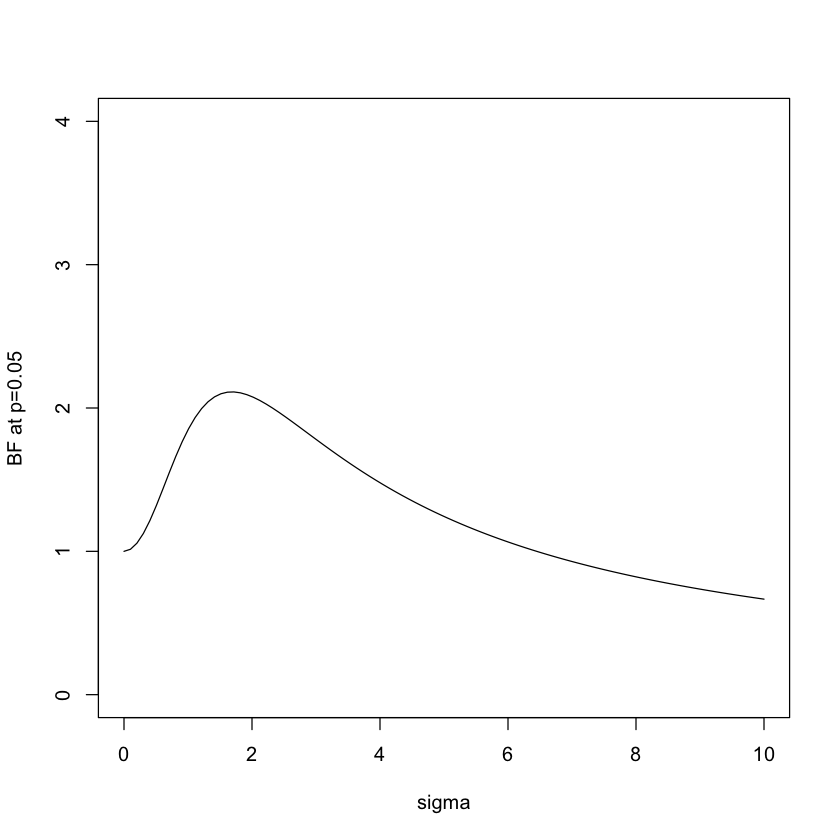

In [22]:
s = seq(0,10,length=100)
plot(s,BF(1.96,s),xlab="sigma",ylab="BF at p=0.05",type="l",ylim=c(0,4))

## p-value provides an upper bound of Bayes factor


Here the horizontal line shows the bound on the Bayes Factor computed by Sellke et al.

And here is the same plot for $d=2.58$ ($p=0.01$):

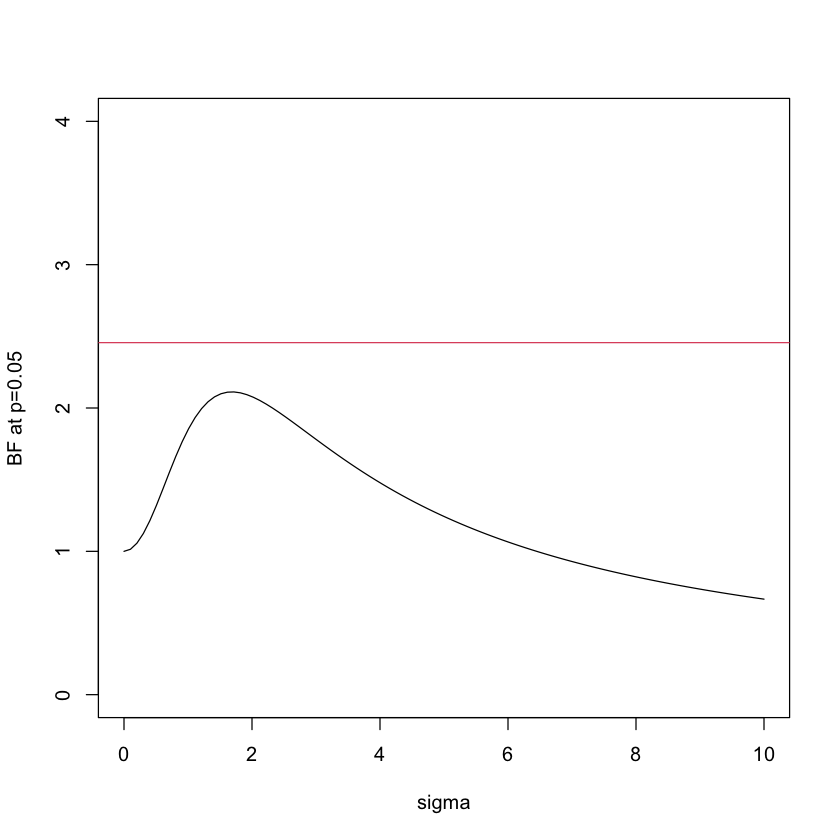

In [23]:
s = seq(0,10,length=100)
plot(s,BF(1.96,s),xlab="sigma",ylab="BF at p=0.05",type="l",ylim=c(0,4))
BFbound=function(p){1/(-exp(1)*p*log(p))}
abline(h=BFbound(0.05),col=2)

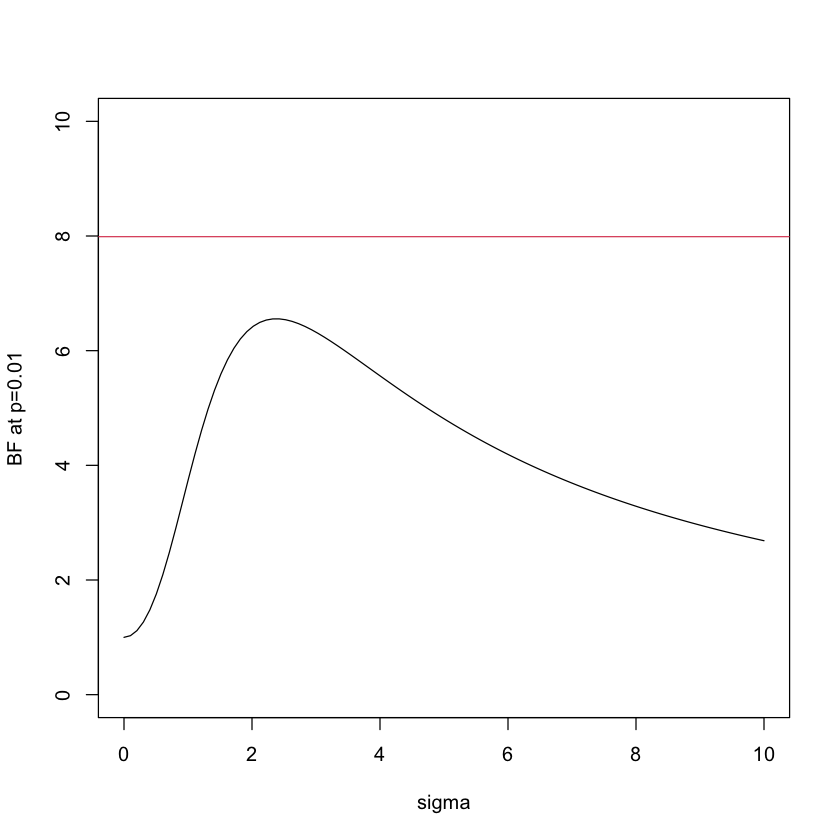

In [24]:
plot(s,BF(2.58,s),xlab="sigma",ylab="BF at p=0.01",type="l",ylim=c(0,10))
abline(h=BFbound(0.01),col=2)